In [ ]:
# Some flags that integrate with Google Colab UI
UPLOAD_PREDS = "False" #@param ['False', 'True']
SAVE_PREDS = "True" #@param ['False', 'True']
MODEL_NAME = 'GTRUDA' #@param {type:"string"}
MODEL_ID = '' #@param {type:"string"}

# Ideas to try:
- [ ] Look into other dimensionality reduction techniques (UMAP, LDA, etc.) See [here](https://www.kaggle.com/sivakarsiva/pca-vs-lda-vs-umap-vs-t-sne)
- [ ] Train autoencoder and final regressor layer(s) separately to finetune.
- [ ] Learn how to make custom loss functions for PyTorch, including how to implement the backwards step. (You don't need to implement backwards as long as you only use built-in torch functions to compose the loss function. Remember to vectorise as much as possible)
- [ ] Apply AutoML techniques using [MLJar](https://github.com/mljar/mljar-supervised) or [autoVIML](https://pypi.org/project/autoviml/).
- [ ] Engineer exhaustive interaction features (`PolynomialFeatures`) [x] and prune using various [feature selection techniues](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) [ ].
- [ ] [Bayesian optimisation](https://github.com/fmfn/BayesianOptimization) for hyperparameter search.
- [ ] Design custom loss / scoring function that balances performance with reliability.
- [ ] Try applying feature neutralisation to (a copy of) the _target_ column and train with that as the new target. i.e. model only learns the signal that isn't linearly accounted for. 
- [ ] Custom scoring function (sum of spearman over eras and lowest era spearman). 
- [ ] PCA on polynomial features. 
- [ ] Experiment with [Sklearn's mutual information feature selection](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection)
- [ ] Add noise to features in cross-validation test set to reduce feature dependence.
- [ ] Use [numba](https://www.youtube.com/watch?v=x58W9A2lnQc) to speed up numeric operations where necessary and possible. 
- [x] Improve autoencoder by using a better error function. Jenson-Shannon distance, for example. But is it differentiable?
- [x] Improve training function so that there are separate optimisers and learning rates for the autoencoder and the predictor.
- [x] Train and save key models to file, to save time in future comparisons (e.g. for baseline comparison). 
- [x] Incorporate fully-connected layers into autoencoder net. 
- [x] Use [shuffling technique](https://forum.numer.ai/t/feature-selection-by-marcos-lopez-de-prado/3170) for feature selection. Turns out this is just sklearn's permuation selection?
- [x] Check out [this guy's NN architecture](https://forum.numer.ai/t/nn-architecture-for-0-03-corr-on-validation-set/3145/5).
- [x] Implement 1D convolutions in a NN, which can supposedly capture correlations across many features.
- [x] Use a linear model (e.g. Lasso) to find predictive base features. Use these to do extended feature engineering (`PolynomialFeatures`).
- [x] Use hierarchical clustering (of correlations) to evaluate correlational clusters in the features.
- [x] Implement neural net model
- [x] Make final predictions and uploading work (reliably) with neutralisation.
- [x] Implement Numerai's official example as a baseline model. 
- [x] Switch to per-era feauture neutralisation
- [x] Implement [feature neutralisation](https://www.kaggle.com/code1110/janestreet-avoid-overfit-feature-neutralization).
- [x] Add [Colab form elements](https://colab.research.google.com/notebooks/forms.ipynb#scrollTo=3jKM6GfzlgpS) to development notebook to make R&D easier. 
- [x] Build tools to measure (and visualise) [feature exposure of model](https://forum.numer.ai/t/model-diagnostics-feature-exposure/899).
- [x] Engineer supporting features for each category: mean, std., difference, etc.
- [x] Enhance CSV read, concat, and convert performance.
- [x] Come up with a tidy way to do train and validate in one dataset.
- [x] See whether the datasets change from week to week. In what ways?
- [x] Tidy up EraEnsemble class to adhere to sklearn API

Current deployment scores (validation):
```
Spearman:	    0.0215
Sharpe:		  0.9875
Max exposure:	0.1931
RMS exposure:	0.0816
```


Explanation of Numerai scoring metrics from [this article](https://tit-btcqash.medium.com/a-comprehensive-guide-to-competing-at-numerai-70b356edbe07)

- `Corr`: Correlation coefficient between the submitted stock price prediction result and the target answer.
- `MMC`: Meta model contribution (MMC) indicates how valuable your model’s predictions are to Numerai’s meta model. Predictions that are very original and moderately accurate will have higher MMC than very accurate but unoriginal predictions. [Learn more about MMC here](https://medium.com/numerai/a-new-data-science-competition-where-being-different-pays-251c2aecc40a).
- `FNC`: Feature neutral correlation (FNC) is your model’s correlation with the target, after its predictions have been neutralized to all of Numerai’s features. [Learn more about FNC here](https://forum.numer.ai/t/model-diagnostics-feature-exposure/899).
- Rep: Rep (reputation) is the weighted average of that metric over the past 20 rounds, and is what’s used to rank users on the leaderboard. [Learn more about reputation here](https://docs.numer.ai/tournament/reputation).

# Setup

## Connecting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
from pathlib import Path
DIR = Path('gdrive/MyDrive/numerai')
DATADIR = DIR / 'data'
SRCDIR = DIR / 'src'
RESULTDIR = DIR / 'results'

In [ ]:
# Copy .env from numerai folder to root dir
!cp gdrive/MyDrive/Data/numerai/.env .env

## Installing and Importing Dependencies
First, we install and import the necessary packages. This cell is currently set *not* to print any output; if you run into any issues and need to check for error messages, comment out the `%%capture` line

In [ ]:
%%capture
# install
!pip uninstall --no-input pandas
!pip install --upgrade python-dotenv fastai numerapi
!pip install ipython-autotime
!pip install torchmetrics

# import dependencies
import gc
import os
import csv
from dotenv import load_dotenv, find_dotenv
from getpass import getpass
import numerapi
from fastai.tabular.all import *
from pathlib import Path
from scipy.stats import spearmanr
import sklearn.linear_model

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import torch

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set sensible defaults for plotting
sns.set()
sns.set_style("ticks")
sns.set_context('paper')

# Get number of CPUs
import multiprocessing
CPUs = multiprocessing.cpu_count()
print(f"CPU count: {CPUs}")

%load_ext autotime

CPU count: 4
time: 83.1 µs (started: 2021-07-08 12:16:11 +00:00)


## Setting up numerapi
We will use the [numerapi](https://github.com/uuazed/numerapi) package to access the data and make submissions. For this to work, numerapi needs to use your API keys (which can be obtained [here](https://numer.ai/submit)). We will set up two main ways of passing these API keys to a numerapi instance:
1. Read a `.env` file using the `python-dotenv` package. This will require you to upload a `.env` file (which contains your secret key and should *not* be kept under version control). Using this method means you will not have to directly enter your keys each time you use this notebook, though you will need to re-upload the `.env` file.
2. Manually entering the API keys -- if you don't have access to, or don't want to mess with, your `.env` file.

If you have a `.env` file, upload it to the default working directory, `content`, now. In either case, run the cell below to set up the numerapi instance. See [Appendix A](#app_a) for instructions on generating and downloading a .env file.

In [ ]:
# Load the numerapi credentials from .env or prompt for them if not available
def credential():
    dotenv_path = find_dotenv()
    load_dotenv(dotenv_path)

    if os.getenv("NUMERAI_PUBLIC_KEY"):
        print("Loaded Numerai Public Key into Global Environment!")
    else:
        os.environ["NUMERAI_PUBLIC_KEY"] = getpass("Please enter your Numerai Public Key. You can find your key here: https://numer.ai/submit -> ")

    if os.getenv("NUMERAI_SECRET_KEY"):
        print("Loaded Numerai Secret Key into Global Environment!")
    else:
        os.environ["NUMERAI_SECRET_KEY"] = getpass("Please enter your Numerai Secret Key. You can find your key here: https://numer.ai/submit -> ")

credential()
public_key = os.environ.get("NUMERAI_PUBLIC_KEY")
secret_key = os.environ.get("NUMERAI_SECRET_KEY")
napi = numerapi.NumerAPI(verbosity="info", public_id=public_key, secret_key=secret_key)

You can read up on the functionality of numerapi [here](https://github.com/uuazed/numerapi). You can use it to download the competition data, view other numerai users' public profiles, check submission status, manage your stake, and much more. In this case, we'll only be using it to download competition data and submit predictions.



# Data preparation


## Downloading Competition Data
In a more structured project, you'll probably want to keep the data in a seprate directory from your scripts etc. You could also link google colab to your google drive and store the data there in order to avoid needing to download and process the data every time. In this case, however, we'll keep everything in `./content`, and download the data fresh each time.

In [ ]:
# check if a new round has started
if napi.check_new_round():
    print("new round has started within the last 24hours!")
else:
    print("no new round within the last 24 hours")

In [ ]:
# Download the current dataset unless it's already there
if not os.path.exists(f'{DATADIR}/numerai_dataset_{napi.get_current_round()}'):
    napi.download_current_dataset(dest_path=DATADIR, unzip=True)
else:
    print("Current round already downloaded")

## Reading the data into memory

If you look at the files we downloaded above, you'll see a `numerai_tournament_data.csv` file and a `numerai_training_data.csv` file. The "tournament" file contains many rows with targets which we can use for validation, so let's extract those and combine them with our training set. 

In [ ]:
# Get the current round
ROUND_NUM = napi.get_current_round()
print(f"Round number {ROUND_NUM}")

train_file = Path(f'{DATADIR}/numerai_dataset_{ROUND_NUM}/numerai_training_data.csv')
tourn_file = Path(f'{DATADIR}/numerai_dataset_{ROUND_NUM}/numerai_tournament_data.csv')

# Load training column names only, so we can specify data types
with open(train_file, 'r') as f:
    column_names = next(csv.reader(f))
    print(f"Detected {len(column_names)} columns")

# Specify the datatypes in memory-efficient way
DTYPES = {c: 'float16' for c in column_names if c.startswith(('feature', 'target'))}

# training data contains features and targets
print('Reading training data...')
df_train = pd.read_csv(train_file, dtype=DTYPES, engine='c').set_index("id")

# tournament data contains features only (for the test rows)
print('Reading tournament data...')
df_tourn = pd.read_csv(tourn_file, dtype=DTYPES, engine='c').set_index("id")

# concatenate the training and validation data
print('Concatenating...')
df = pd.concat([df_train, df_tourn[df_tourn['data_type'] == 'validation']])

# Discard the other dataframes from memory
print('Garbage collection...')
# del df_tourn
del df_train

# Check dataframe information
df.info()

Round number 271
Detected 314 columns
Reading training data...
Reading tournament data...
Concatenating...
Garbage collection...
<class 'pandas.core.frame.DataFrame'>
Index: 639587 entries, n000315175b67977 to nffe5d84fb971b26
Columns: 313 entries, era to target
dtypes: float16(311), object(2)
memory usage: 394.0+ MB
time: 1min 14s (started: 2021-07-08 12:16:12 +00:00)


In [ ]:
print(df.data_type.unique())
print(df_tourn.data_type.unique())

['train' 'validation']
['validation' 'test' 'live']
time: 89.6 ms (started: 2021-07-08 12:17:27 +00:00)


In [ ]:
# Get the names of the features
RAW_FEAT_COLS = [f for f in df.columns if "feature" in f]
FEAT_COLS = RAW_FEAT_COLS # identical prior to feature engineering

# Get the groups of the features
FEAT_GROUPS = {
    g: [c for c in RAW_FEAT_COLS if c.startswith(f"feature_{g}")]
    for g in ["intelligence", "wisdom", "charisma", "dexterity", "strength", "constitution"]
}

In [ ]:
# Convert era to int32 in training data
pd.options.mode.chained_assignment = 'warn'
df['era'] = df['era'].str[3:].astype('int32')

# Exploration

In [ ]:
print('Train:\t', df[df.data_type == 'train'].shape)
print('Val:\t', df[df.data_type == 'validation'].shape)

Train:	 (501808, 313)
Val:	 (137779, 313)
time: 1.21 s (started: 2021-07-08 12:17:27 +00:00)


In [ ]:
df.sample(10)

,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,feature_charisma26,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
n2b99d2a14881c17,115,train,0.25,0.25,0.25,0.25,0.50,0.25,0.25,0.00,0.25,0.25,0.00,0.50,0.50,0.75,0.00,0.00,1.00,0.75,0.50,0.50,0.75,0.50,0.25,0.50,0.25,0.25,0.50,0.75,0.00,0.50,0.75,0.75,0.75,0.50,0.00,0.75,0.00,0.25,...,1.00,0.25,1.00,0.50,0.00,0.50,1.00,0.75,0.00,1.00,0.50,1.00,0.75,0.50,0.25,1.00,0.25,0.50,1.00,0.50,0.50,1.00,0.00,0.75,1.00,0.25,0.75,0.75,0.75,0.75,1.00,0.75,0.25,0.75,0.75,0.25,0.25,0.00,0.00,0.75
n2a6bb31a1cc3274,32,train,0.00,0.50,0.50,0.00,0.75,0.00,0.00,0.00,0.50,0.50,0.00,0.75,0.50,0.25,0.75,0.75,0.50,0.75,1.00,0.50,0.50,1.00,0.25,0.75,0.50,0.50,0.50,0.50,0.75,0.50,0.75,0.75,0.75,0.50,0.50,0.50,0.50,0.50,...,0.25,0.25,0.75,0.25,0.25,0.50,1.00,1.00,0.75,0.50,0.50,0.75,0.25,0.75,0.50,0.50,0.00,0.50,0.50,1.00,1.00,0.75,0.25,0.75,0.50,0.25,1.00,0.50,0.25,0.25,0.25,0.75,0.50,0.50,0.50,0.25,0.75,0.50,0.50,0.25
nc0d2df3475404f9,25,train,0.75,0.75,0.75,0.75,0.25,0.00,0.00,0.50,0.00,0.00,1.00,0.25,0.25,0.75,1.00,0.75,1.00,0.25,0.50,0.75,1.00,0.75,0.75,0.75,0.50,0.75,0.75,0.75,0.75,0.50,0.25,0.75,0.75,1.00,1.00,0.75,0.50,0.50,...,0.00,0.50,0.25,0.00,0.50,0.00,0.00,0.75,0.75,0.25,0.25,0.00,0.00,0.50,0.25,0.50,0.25,0.25,0.00,0.75,0.25,0.25,0.75,0.25,0.50,0.25,0.00,0.00,0.25,0.25,0.25,0.25,0.75,0.50,0.25,0.25,0.75,0.75,0.50,0.75
nd1f018a9f0de050,65,train,0.75,1.00,1.00,0.75,0.00,0.25,0.25,0.50,1.00,0.75,1.00,0.25,1.00,0.75,0.00,0.25,1.00,0.25,0.50,0.50,0.00,0.00,0.75,0.50,0.25,0.75,0.50,0.75,0.25,0.50,1.00,0.75,0.25,0.50,0.50,0.50,0.50,0.75,...,0.50,0.50,0.00,0.25,0.50,0.50,0.00,0.75,0.75,0.00,0.25,0.00,0.00,0.75,0.75,0.50,0.50,0.00,0.75,0.50,0.75,0.00,0.25,0.50,0.50,0.75,0.25,0.00,0.00,0.25,0.25,0.50,0.00,0.00,0.00,0.75,0.00,0.50,0.75,0.75
n263fcf7aa83f0d3,43,train,0.50,0.00,0.25,0.25,0.25,0.25,0.25,0.25,0.75,0.50,0.50,0.50,1.00,1.00,1.00,0.50,0.75,0.00,0.00,0.50,0.00,1.00,0.25,0.75,0.50,0.75,0.50,0.50,0.25,0.75,1.00,0.00,0.00,0.75,1.00,1.00,0.75,0.25,...,0.25,0.25,0.50,0.25,0.25,0.00,0.50,0.50,0.50,0.25,0.50,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.25,0.50,0.25,0.50,0.50,0.50,0.50,0.25,0.50,0.75,0.25,0.25,0.25,0.50,0.25,0.50,0.50,0.25,0.75,0.50,0.50,0.75
n3072e80eb20565a,53,train,0.25,0.50,0.25,0.00,0.50,0.25,0.00,0.25,0.25,0.00,0.00,0.50,0.50,1.00,0.75,1.00,0.50,0.25,0.75,0.50,0.25,1.00,0.00,0.00,0.25,0.50,0.50,0.25,1.00,0.00,0.50,1.00,0.00,1.00,0.75,1.00,0.75,0.75,...,0.25,0.75,0.25,0.25,0.75,0.75,0.50,0.25,0.75,0.50,0.50,0.75,1.00,0.50,0.50,0.25,0.50,0.25,0.50,0.50,0.25,0.25,1.00,0.25,0.25,0.25,0.50,0.50,0.75,0.75,0.75,0

time: 132 ms (started: 2021-07-08 12:17:28 +00:00)


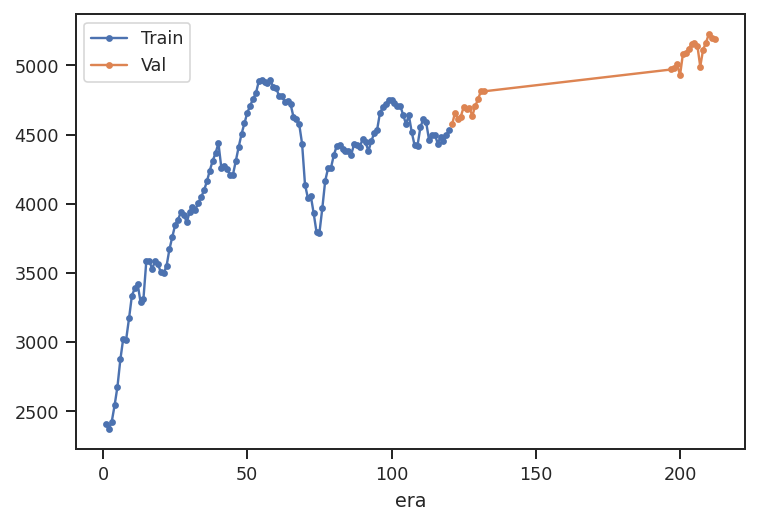

time: 1.44 s (started: 2021-07-08 12:17:29 +00:00)


In [ ]:
df[df.data_type == 'train'].groupby('era').size().plot(marker='.', label='Train')
df[df.data_type == 'validation'].groupby('era').size().plot(marker='.', label='Val')
plt.legend()

# Evaluation Metrics

In this section, we will define two key evaluation metrics used to assess the performance of models before submitting to the tournament. These metrics are:
- Average Spearman Correlation per era: The sum of each era's Spearman correlation divided by the number of eras.
- Sharpe Ratio: The average correlation per era divided by the standard deviation of the correlations per era.

Both are defined in reasonable detail [here](https://wandb.ai/carlolepelaars/numerai_tutorial/reports/How-to-get-Started-With-Numerai--VmlldzoxODU0NTQ). The methods defined below are modified versions of the methods described in that post.

In [ ]:
def score_corr(df: pd.DataFrame) -> np.float32:
    """
    Calculate the correlation by using grouped per-era data
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: The average per-era correlations.
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """ Calculate Spearman correlation for Pandas' apply method """
        return spearmanr(sub_df["target"],  sub_df["prediction"])[0]
    corrs = df.groupby("era").apply(_score)
    return corrs.mean()

def score_spear(y_true, y_pred, axis=0):
    """Calculate Spearman correlation"""
    return spearmanr(y_true, y_pred, axis=axis)[0]

def score_sharpe(df: pd.DataFrame) -> np.float32:
    """
    Calculate the Sharpe ratio by using grouped per-era data
    :param df: A Pandas DataFrame containing the columns "era", "target" and "prediction"
    :return: The Sharpe ratio for your predictions.
    """
    def _score(sub_df: pd.DataFrame) -> np.float32:
        """ Calculate Spearman correlation for Pandas' apply method """
        return spearmanr(sub_df["target"],  sub_df["prediction"])[0]
    corrs = df.groupby("era").apply(_score)
    return corrs.mean() / corrs.std()

def feature_exposures(df: pd.DataFrame, preds: pd.Series, feat_cols=None):
    """ Calculate feature exposure of a model's predictions.
        https://forum.numer.ai/t/model-diagnostics-feature-exposure/899
    """
    if feat_cols is None:
        feat_cols = RAW_FEAT_COLS
        # Use the raw feature columns by default

    exposures = []
    for f in feat_cols:
        fe = spearmanr(preds, df[f])[0]
        exposures.append(fe)
    return np.array(exposures)

def scores(df: pd.DataFrame, verbose=False, feat_cols=None) -> (np.float32, np.float32):
    """ Score models across a variety of metrics. """
    if feat_cols is None:
        feat_cols = RAW_FEAT_COLS
    val_sharpe = score_sharpe(df)
    val_corr = score_corr(df)
    fe = feature_exposures(df, df['prediction'], feat_cols=feat_cols)
    max_fe = np.max(fe)
    rms_fe = np.sqrt(np.mean(np.square(fe)))

    if verbose:
        print(f'Spearman:\t{val_corr:.4f}')
        print(f'Sharpe:\t\t{val_sharpe:.4f}')
        print(f'Max exposure:\t{max_fe:.4f}')
        print(f'RMS exposure:\t{rms_fe:.4f}')

    return val_corr, val_sharpe, max_fe, rms_fe

def visualise_feat_exposure(df: pd.DataFrame, model, feat_cols: list, fe_cols: list):
    """ Visualises mean and max feature exposure for a trained model over eras
    """
    _df = df.copy()
    _df['prediction'] = model.predict(_df[feat_cols])

    maxes, means, eras = [], [], _df.era.unique()
    for era in tqdm(eras):
        era_df = _df[_df.era == era]
        era_fe = feature_exposures(era_df, era_df['prediction'], feat_cols=fe_cols)
        maxes.append(era_fe.max())
        means.append(np.sqrt(np.mean(np.square(era_fe))))

    plt.plot(eras, means, marker='.', label='Mean FE')
    plt.plot(eras, maxes, marker='.', label='Max FE')
    plt.legend()
    plt.xlabel('Era')
    plt.ylabel('Exposure')
    plt.title(f'Exposure of {len(fe_cols)} features by era')


# Modeling the Data

## Training models

### Linear baseline
This model closely follows the tutorial example [here](https://colab.research.google.com/github/numerai/example-scripts/blob/master/making-your-first-submission-on-numerai.ipynb). We will use the `scikit-learn` package, with which we can implement and fit our regression model in just a couple of lines of code.

In [ ]:
model = sklearn.linear_model.LinearRegression()
model = model.fit(df[df.data_type=='train'][FEAT_COLS], df[df.data_type=='train']['target'])

# Evaluate the model on validation set
_df = df[df.data_type=='validation'].copy()
_df['prediction'] = model.predict(_df[FEAT_COLS])
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)
# visualise_feat_exposure(df, model, FEAT_COLS, RAW_FEAT_COLS)

Spearman:	0.0162
Sharpe:		0.5237
Max exposure:	0.2296
RMS exposure:	0.1012
time: 22.3 s (started: 2021-07-07 13:31:31 +00:00)


### Numerai baseline 

In [ ]:
# Numerai's example model baseline
from xgboost import XGBRegressor
MODEL_FILE = SRCDIR / 'numerai_example_model.xgb'
RETRAIN_EX_MODEL = False
ex_model = XGBRegressor(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=1, colsample_bytree=0.1)

if MODEL_FILE.is_file() and not RETRAIN_EX_MODEL:
    print(f"Loading pre-trained model from '{MODEL_FILE}' ...")
    ex_model.load_model(str(MODEL_FILE))
else:
    print("Training model...")
    ex_model.fit(df[df.data_type=='train'][FEAT_COLS], df[df.data_type=='train']['target'])
    print(f"Saving model to '{MODEL_FILE}' ...")
    ex_model.save_model(str(MODEL_FILE))

In [ ]:
print("Generating predictions...")
# df['example_prediction'] = ex_model.predict(df[RAW_FEAT_COLS])
# df_tourn['example_prediction'] = ex_model.predict(df_tourn[RAW_FEAT_COLS])
_df = df[df.data_type=='validation'].copy()
_df['prediction'] = ex_model.predict(_df[RAW_FEAT_COLS])
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)

Generating predictions...
Spearman:	0.0081
Sharpe:		0.3521
Max exposure:	0.4322
RMS exposure:	0.2009
time: 38.4 s (started: 2021-04-21 21:05:41 +00:00)


### Deployment baseline: V3X

In [ ]:
# V3X model, by Gianluca Truda

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, make_scorer

class EraEnsemble(BaseEstimator):
    def __init__(self,
                 n_subs=10,
                 pca_frac=None,
                 subalg=XGBRegressor,
                #  subalg_args={},
                 mainalg=LassoCV,
                #  mainalg_args={},
                 ):
        self.n_subs = n_subs
        self.submodels = []
        self.sub_preds = []
        self.pca_frac = pca_frac
        self.transforms = []
        self.subalg = subalg
        self.mainalg = mainalg
        # self.subalg_args = subalg_args,
        # self.mainalg_args = mainalg_args

    def get_params(self, *args, **kwargs):
        return {
            'n_subs': self.n_subs,
            'pca_frac': self.pca_frac,
            'subalg': self.subalg,
            'mainalg': self.mainalg,
            }

    def fit(self, df, y, validation=None):
        # Figure out how to partition eras
        n_eras = df.era.nunique()
        min_era = df.era.min()
        max_era = df.era.max()
        STEP = n_eras//self.n_subs

        # Loop over era ranges
        for i in range(min_era, max_era, STEP):
            _data = df[df.era.between(i, i+STEP)]
            _target = _data['target']
            _data = _data[FEAT_COLS]
            if self.pca_frac < 1.0:
                _pca = PCA(n_components=self.pca_frac).fit(_data)
                _data = _pca.transform(_data)
                self.transforms.append(_pca)
            if self.subalg == XGBRegressor:
                submodel = self.subalg(verbosity=0).fit(_data, _target)
            else:
                submodel = self.subalg().fit(_data, _target)
            self.submodels.append(submodel)
            if self.pca_frac < 1.0:
                _preds = submodel.predict(_pca.transform(df[FEAT_COLS]))
            else:
                _preds = submodel.predict(df[FEAT_COLS])
            self.sub_preds.append(_preds)
        _X = np.array(self.sub_preds).T
        self.mainmodel = self.mainalg().fit(_X, y)

        return self

    def predict(self, df):
        _preds = []
        for i, sm in enumerate(self.submodels):
            if self.pca_frac < 1.0:
                _data = self.transforms[i].transform(df[FEAT_COLS])
            else:
                _data = df[FEAT_COLS]
            _preds.append(sm.predict(_data))
        _X = np.array(_preds).T

        return self.mainmodel.predict(_X)


model = EraEnsemble(
    mainalg=RidgeCV,
    n_subs=3,
    pca_frac=1.0,
    subalg=XGBRegressor,
)

print('Fitting model...')
model.fit(df[df.data_type=='train'], df[df.data_type=='train']['target'], validation=df[df.data_type=='validation'])
print('Making predictions on validation data...')
_df = df[df.data_type=='validation'].copy()
_df['prediction'] = model.predict(_df[FEAT_COLS])
print('Scoring model...')
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)
# visualise_feat_exposure(df, model, FEAT_COLS, RAW_FEAT_COLS)

Fitting model...


### Development models

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.cuda.amp import autocast
from torchsummary import summary
from sklearn.model_selection import train_test_split
from torchmetrics import PearsonCorrcoef

# Enable CUDA GPU support, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)

# Write my own dataset object
class NumeraiDataset(Dataset):

    def __init__(self, df: pd.DataFrame):
        self.df = df[FEAT_COLS].copy()
        self.df = self.df.reset_index(drop=True)
        self.target = df['target'].values

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        X = torch.as_tensor(self.df.iloc[idx, :].values, dtype=torch.float32)
        y = torch.as_tensor(self.target[idx], dtype=torch.float32)

        return (X, y)

# Testing Dataset with a dataloader
# smol_dataset = NumeraiDataset(df.sample(30).reset_index(drop=True))
# smol_dloader = DataLoader(smol_dataset, batch_size=10, shuffle=True, num_workers=1)
# for i, data in enumerate(smol_dloader):
#     X, y = data
#     X, y = X.to(device), y.to(device)
#     print(i, X.shape, type(X), y.shape, type(y))


def train_net(net, trainloader, valloader, enc_optimiser, pred_optimiser,
              enc_criterion, pred_criterion, pred_crit_multiplier=1,
              epochs=1, ae_pretrain_epochs=0, checkpoints=None):
    """ Train the network for the specified number of epochs, tracking train
    and validation losses.
    """

    if checkpoints is not None:
        checkpoints = Path(checkpoints)
        if not os.path.exists(checkpoints):
            os.makedirs(str(checkpoints))

    # Create lists for tracking loss and accuracy
    epoch_losses_enc, epoch_val_losses_enc, epoch_losses_pred, epoch_val_losses_pred = [], [], [], []

    try:
        # loop over the dataset multiple times
        for epoch in tqdm(range(epochs), desc='Train'):
            running_loss_enc, running_loss_pred = 0.0, 0.0

            # Get a minibatch of data
            for i, (inputs, labels) in enumerate(trainloader, 0):

                # Move data to GPU (if available)
                inputs, labels = inputs.to(device), labels.to(device)

                # Reset gradients
                enc_optimiser.zero_grad()
                pred_optimiser.zero_grad()

                # Forward pass (of autoencoder)
                outputs = net(inputs)

                # Calculate loss of autoencoder
                enc_loss = enc_criterion(outputs, inputs)

                # Update and log training losses for AE
                running_loss_enc += enc_loss.item()

                # Backpropagation and weight updating for AE
                enc_loss.backward()
                enc_optimiser.step()

                # Don't do loss and backprop on predictor if pretraining AE
                if epoch >= ae_pretrain_epochs:
                    # Calculate the loss of predictor
                    preds = net.predict(inputs)
                    pred_loss = pred_crit_multiplier * pred_criterion(preds, labels)
                    running_loss_pred += pred_loss.item()
                    # Backprop predictor
                    pred_loss.backward()
                    pred_optimiser.step()

            # Calculate avg loss over epoch
            epoch_losses_enc.append(running_loss_enc / len(trainloader.dataset))
            epoch_losses_pred.append(running_loss_pred / len(trainloader.dataset))

            print(f"Training loss | Autoencoder: {epoch_losses_enc[-1]:.4f}\tPredictor: {epoch_losses_pred[-1]:.4f}")

            # Calculate validation loss over epoch
            val_loss_enc, val_loss_pred = 0.0, 0.0
            val_steps = 0
            for i, data in enumerate(valloader, 0):
                with torch.no_grad():
                    inputs, labels = data
                    # Move data to GPU (if available)
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = net(inputs)
                    enc_loss = enc_criterion(outputs, inputs)
                    val_loss_enc += enc_loss.item()
                    preds = net.predict(inputs)
                    pred_loss = pred_crit_multiplier * pred_criterion(preds, labels)
                    val_loss_pred += pred_loss.item()
                    val_steps += 1
            epoch_val_losses_enc.append(val_loss_enc / len(valloader.dataset))
            epoch_val_losses_pred.append(val_loss_pred / len(valloader.dataset))
            print(f"Validation loss | Autoencoder: {epoch_val_losses_enc[-1]:.4f}\tPredictor: {epoch_val_losses_pred[-1]:.4f}")

            # Checkpointing model states
            if checkpoints is not None and epoch > 10:
                if epoch_val_losses_enc[-1] <= np.min(epoch_val_losses_enc[1:]) and epoch_val_losses_pred[-1] <= np.min(epoch_val_losses_pred[1:]):
                    print("Best model. Checkpointing...")
                    torch.save({
                        'epoch': epoch,
                        'model_state_dict': net.state_dict(),
                        'enc_optimizer_state_dict': enc_optimiser.state_dict(),
                        'pred_optimizer_state_dict': pred_optimiser.state_dict(),
                        'val_losses_pred': epoch_val_losses_pred,
                        'val_losses_enc': epoch_val_losses_enc,
                    }, checkpoints/'best_checkpoint.tar')

            # Plotting learning curves
            if (epoch + 1) % 20 == 0:
                plt.plot(epoch_losses_enc[-20:], label='Encoder train loss')
                plt.plot(epoch_val_losses_enc[-20:], label='Encoder val. loss')
                plt.legend()
                plt.show()
                plt.plot(epoch_losses_pred[-20:], label='Predictor train loss')
                plt.plot(epoch_val_losses_pred[-20:], label='Predictor val. loss')
                plt.legend()
                plt.show()


        print('\nTraining complete')

    except KeyboardInterrupt as e:
        print(f'\nKeyboard interrupt! Stopping training after {epoch} of {epochs}...')

    return epoch_losses_enc, epoch_val_losses_enc, epoch_losses_pred, epoch_val_losses_pred


class FCNet(nn.Module):
    def __init__(self):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(310, 128)
        # self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x.reshape(x.shape[0],)

class Autoencoder(nn.Module):
    # Based on https://github.com/astorfi/differentially-private-cgan/blob/master/UCI/autoencoder.py

    def __init__(self):
        super(Autoencoder, self).__init__()
        n_channels_base = 4

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=n_channels_base, kernel_size=5, stride=2, padding=0, dilation=1,
                      groups=1, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=n_channels_base, out_channels=2 * n_channels_base, kernel_size=5, stride=2, padding=0,
                      dilation=1,
                      groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(2 * n_channels_base),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=2 * n_channels_base, out_channels=4 * n_channels_base, kernel_size=5, stride=3,
                      padding=0, dilation=1,
                      groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(4 * n_channels_base),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=4 * n_channels_base, out_channels=8 * n_channels_base, kernel_size=5, stride=3,
                      padding=0, dilation=1,
                      groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(8 * n_channels_base),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(in_channels=8 * n_channels_base, out_channels=16 * n_channels_base, kernel_size=3, stride=1,
                      padding=0, dilation=1,
                      groups=1, bias=True, padding_mode='zeros'),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16 * n_channels_base, out_channels=8 * n_channels_base, kernel_size=5,
                               stride=1, padding=0, dilation=1,
                               groups=1, bias=True, padding_mode='zeros'),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(in_channels=8 * n_channels_base, out_channels=4 * n_channels_base, kernel_size=5,
                               stride=4, padding=0,
                               dilation=1,
                               groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(4 * n_channels_base),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(in_channels=4 * n_channels_base, out_channels=2 * n_channels_base, kernel_size=7,
                               stride=4,
                               padding=0, dilation=1,
                               groups=1, bias=True, padding_mode='zeros'),
            nn.BatchNorm1d(2 * n_channels_base),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose1d(in_channels=2 * n_channels_base, out_channels=1, kernel_size=10, stride=2,
                               padding=0, dilation=1,
                               groups=1, bias=True, padding_mode='zeros'),
            nn.Sigmoid(),
        )

        self.autoencoder = nn.Sequential(
            self.encoder,
            self.decoder,
        )

        self.fc = nn.Sequential(
           nn.Linear(in_features=320+310, out_features=32),
           nn.ReLU(),
           nn.Linear(in_features=32, out_features=8),
           nn.ReLU(),
           nn.Linear(in_features=8, out_features=1),
           nn.Sigmoid(),
        )


    def forward(self, x):
        x = self.encoder(x.view(-1, 1, x.shape[1]))
        x = self.decoder(x)
        return torch.squeeze(x, dim=1)

    def encode(self, x):
        x = self.encoder(x.view(-1, 1, x.shape[1]))
        return torch.squeeze(x, dim=1)

    def decode(self, x):
        x = self.decoder(x)
        return torch.squeeze(x, dim=1)

    def predict(self, x):
        with torch.no_grad():
            x_enc = self.encode(x)
        x_enc = x_enc.view(-1, x_enc.shape[1]*x_enc.shape[2])
        ins = torch.cat([x_enc, x], dim=1)
        out = self.fc(ins)
        return torch.squeeze(out, dim=1)

net = Autoencoder().to(device)
net.load_state_dict(torch.load(SRCDIR / 'torch_checkpoints/best_checkpoint.tar')['model_state_dict'])
summary(net, (len(FEAT_COLS), ))


Device: cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 4, 153]              24
            Conv1d-2               [-1, 4, 153]              24
         LeakyReLU-3               [-1, 4, 153]               0
         LeakyReLU-4               [-1, 4, 153]               0
            Conv1d-5                [-1, 8, 75]             168
            Conv1d-6                [-1, 8, 75]             168
       BatchNorm1d-7                [-1, 8, 75]              16
       BatchNorm1d-8                [-1, 8, 75]              16
         LeakyReLU-9                [-1, 8, 75]               0
        LeakyReLU-10                [-1, 8, 75]               0
           Conv1d-11               [-1, 16, 24]             656
           Conv1d-12               [-1, 16, 24]             656
      BatchNorm1d-13               [-1, 16, 24]              32
      BatchNorm1d-14    

In [ ]:
BATCH = 2**15

# Setting up training and validation sets from the train data type (stratified by era)
X, y = df[df.data_type=='train'], df[df.data_type=='train']['target']
X, X_test, y, y_test = train_test_split(X, y, test_size=0.3, stratify=X['era'], random_state=13)

train_dataset = NumeraiDataset(X)
val_dataset = NumeraiDataset(X_test)
trainloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True, num_workers=CPUs)
valloader = DataLoader(val_dataset, batch_size=BATCH, shuffle=False, num_workers=CPUs)

epoch_losses_enc, epoch_val_losses_enc, epoch_losses_pred, epoch_val_losses_pred = train_net(
    net,
    trainloader,
    valloader,
    enc_optimiser=optim.Adam(net.autoencoder.parameters(), lr=0.0003),
    pred_optimiser=optim.Adam(net.fc.parameters(), lr=0.01),
    enc_criterion=nn.BCELoss(reduction='sum'),
    # pred_criterion=nn.MSELoss(reduction='sum'),
    pred_criterion=PearsonCorrcoef(),
    pred_crit_multiplier=-1*len(trainloader.dataset),
    epochs=200,
    ae_pretrain_epochs=0,
    checkpoints=SRCDIR/'torch_checkpoints',
)

In [ ]:
plt.plot(range(1, len(epoch_losses_enc) + 1), epoch_losses_enc, label='Encoder train loss')
plt.plot(range(1, len(epoch_val_losses_enc) + 1), epoch_val_losses_enc, label='Encoder val. loss')
plt.xlabel('Epochs')
plt.ylabel('Mean epoch loss')
plt.legend()
plt.show()

plt.plot(range(1, len(epoch_losses_pred) + 1), epoch_losses_pred, label='Predictor train loss')
plt.plot(range(1, len(epoch_val_losses_pred) + 1), epoch_val_losses_pred, label='Predictor val. loss')
plt.xlabel('Epochs')
plt.ylabel('Mean epoch loss')
plt.legend()
plt.show()

In [ ]:
print('\nMaking predictions on validation data...')
_df = df[df.data_type=='validation'].copy()
test_dataset = NumeraiDataset(_df)
testloader = DataLoader(test_dataset, batch_size=2048, shuffle=False, num_workers=CPUs)
preds = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        predicted = list(net.predict(inputs).cpu().numpy())
        preds.extend(predicted)
_df['prediction'] = preds

print('Scoring model...')
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)
# visualise_feat_exposure(df, model, FEAT_COLS, RAW_FEAT_COLS

_df[['target', 'prediction']].hist(sharex=False, sharey=False)
plt.show()
_df[['target', 'prediction']].describe()

In [ ]:
# Save the pytorch model
torch.save(net.state_dict(), SRCDIR / 'ac_predictor_statedict.pt')
# torch.save(net, SRCDIR / 'autoencoder_full.pt')

time: 12.5 ms (started: 2021-07-08 19:13:46 +00:00)


(137779, 64, 5) (137779, 310)
Mean residual: 0.0007
Mean abs. residual: 0.1229
Std. residual: 0.1575


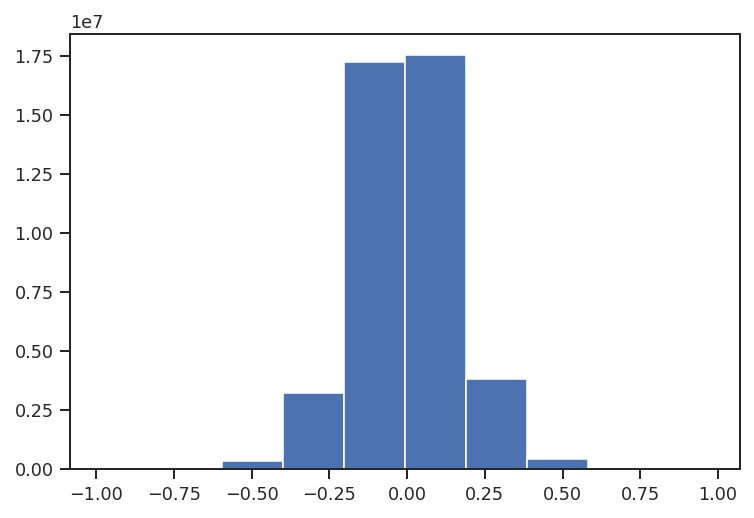

time: 20.6 s (started: 2021-07-08 16:10:34 +00:00)


In [ ]:
_df = df[df.data_type=='validation'].copy()
test_dataset = NumeraiDataset(_df)
testloader = DataLoader(test_dataset, batch_size=_df.shape[0]+1, shuffle=True, num_workers=CPUs)
preds = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        latents = net.encode(inputs)
        outputs = net.decode(latents)
        inputs, latents, outputs = inputs.cpu().numpy(), latents.cpu().numpy(), outputs.cpu().numpy()

print(latents.shape, outputs.shape)

residuals = outputs.flatten() - inputs.flatten()
print(f"Mean residual: {residuals.mean():.4f}")
print(f"Mean abs. residual: {np.abs(residuals).mean():.4f}")
print(f"Std. residual: {residuals.std():.4f}")

plt.hist(residuals)
plt.show()


In [ ]:
# Load a pytorch model
net = Autoencoder().to(device)
net.load_state_dict(torch.load(SRCDIR / 'ac_predictor_statedict.pt'))
print(net.eval())

In [ ]:
# Lets experiment with neural nets a bit
# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

model = MLPRegressor(
    hidden_layer_sizes=(512, 256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=0.005,
    batch_size=512,
    learning_rate='adaptive',
    learning_rate_init=0.001,
    power_t=0.5,
    max_iter=30,
    shuffle=False,
    random_state=None,
    tol=0.00005,
    verbose=True,
    warm_start=False,
    momentum=0.9,
    nesterovs_momentum=True,
    early_stopping=False,
    validation_fraction=0.1,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    n_iter_no_change=10,
    max_fun=15000,
)

# Setting up training and validation sets from the train data type (stratified by era)
X, y = df[df.data_type=='train'], df[df.data_type=='train']['target']
X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=X['era'], random_state=42)
X = X[FEAT_COLS]
_df = X_test
_df['target'] = y_test
sharpe_hist = []
_model_best = None
_sharpe_best = -1.0

print('Fitting model...')
try:
    for i in range(model.max_iter):
        model = model.partial_fit(X, y)
        if i % 3 == 0:
            _df['prediction'] = model.predict(_df[FEAT_COLS])
            val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)
            sharpe_hist.append(val_sharpe)
            if val_sharpe > _sharpe_best:
                _sharpe_best = val_sharpe
                _model_best = model
        if model._no_improvement_count >= model.n_iter_no_change:
            print('Model not improving. Stopping early...')
            model = _model_best
            break
except KeyboardInterrupt as e:
    print(f'Manually terminating early: {i} iters')
    model = _model_best

# Make sure that the best model (in terms of Sharpe) is being used
model = _model_best

print('\nMaking predictions on validation data...')
_df = df[df.data_type=='validation'].copy()
_df['prediction'] = model.predict(_df[FEAT_COLS])
print('Scoring model...')
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)
# visualise_feat_exposure(df, model, FEAT_COLS, RAW_FEAT_COLS)

Current deployment scores (validation):
```
Spearman:	    0.0215
Sharpe:		  0.7300
Max exposure:	0.2138
RMS exposure:	0.1035
```

In [ ]:
plt.plot(model.loss_curve_)
plt.show()
plt.plot(sharpe_hist)
plt.show()

In [ ]:
# Assessing NN layer weights
for i, layer in enumerate(model.coefs_):
    sh = layer.shape
    plt.hist(layer.flatten(), bins=50)
    plt.title(f"Layer {i}: {sh}")
    plt.show()

In [ ]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.model_selection import GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.metrics import mean_squared_error, make_scorer

class ChunkEnsemble(BaseEstimator):
    def __init__(self,
                 n_subs=10,
                 feat_cols=FEAT_COLS,
                 subalg=XGBRegressor,
                #  subalg_args={},
                 mainalg=LassoCV,
                #  mainalg_args={},
                 ):
        self.n_subs = n_subs
        self.feat_cols = feat_cols
        self.submodels = []
        self.sub_preds = []
        self.transforms = []
        self.subalg = subalg
        self.mainalg = mainalg
        # self.subalg_args = subalg_args,
        # self.mainalg_args = mainalg_args

    def get_params(self, *args, **kwargs):
        return {
            'n_subs': self.n_subs,
            'feat_cols': self.feat_cols,
            'subalg': self.subalg,
            'mainalg': self.mainalg,
            }

    def fit(self, df, y):
        # Figure out how to partition eras
        dlen = df.shape[0]
        STEP = dlen//self.n_subs + 1

        # Chop the data (chronologically) into equal-sized chunks
        for i in range(0, dlen, STEP):
            _data = df[i: i+STEP]
            print(_data.shape)
            _target = _data['target']
            _data = _data[self.feat_cols]
            if self.subalg == XGBRegressor:
                submodel = self.subalg(verbosity=0).fit(_data, _target)
            else:
                submodel = self.subalg().fit(_data, _target)
            self.submodels.append(submodel)
            _preds = submodel.predict(df[self.feat_cols])
            self.sub_preds.append(_preds)

        _X = np.array(self.sub_preds).T
        self.mainmodel = self.mainalg().fit(_X, y)

        return self

    def predict(self, df):
        _preds = []
        for i, sm in enumerate(self.submodels):
            _data = df[self.feat_cols]
            _preds.append(sm.predict(_data))
        _X = np.array(_preds).T

        return self.mainmodel.predict(_X)

time: 51.7 ms (started: 2021-04-02 15:47:34 +00:00)


In [ ]:
model = ChunkEnsemble(
    mainalg=RidgeCV,
    n_subs=5,
    subalg=XGBRegressor,
    feat_cols=FEAT_COLS,
)

print('Fitting model...')
model.fit(df[df.data_type=='train'], df[df.data_type=='train']['target'])
print('Making predictions on validation data...')
_df = df[df.data_type=='validation'].copy()
_df['prediction'] = model.predict(_df[FEAT_COLS])
print('Scoring model...')
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)
visualise_feat_exposure(df, model, FEAT_COLS, RAW_FEAT_COLS)

## Feature neutralisation

In [ ]:
from sklearn.preprocessing import MinMaxScaler

def neutralise(df, target="prediction", cols=None, proportion=1.0):
    # https://forum.numer.ai/t/model-diagnostics-feature-exposure/899
    if cols is None:
        cols = [x for x in df.columns if x.startswith('feature')]

    scores = df[target]
    exposures = df[cols].values

    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack((exposures, np.array([np.mean(scores)] * len(exposures)).reshape(-1, 1)))

    scores -= proportion * (exposures @ (np.linalg.pinv(exposures) @ scores.values))
    scores = scores / scores.std()

    # MinMax scaling
    return MinMaxScaler().fit_transform(scores.values.reshape(-1, 1))

def neutralise_by_era(df, *args, **kwargs):
    return np.vstack(df.groupby('era').apply(lambda x: neutralise(x, *args, **kwargs)).values)

time: 12 ms (started: 2021-05-16 16:10:18 +00:00)


In [ ]:
print('Making predictions on validation data...')
_df = df[df.data_type=='validation'].copy()
_df['prediction'] = model.predict(_df[FEAT_COLS])
print('Scoring vanilla model...')
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)
print('----------')

# Grid search over feature neutralisation proportions to find optimal
og_preds = _df['prediction'].values
_results = defaultdict(list)
for prop in tqdm(np.linspace(0.1, 1.0, num=10)):
    _df['prediction'] = og_preds
    _df['prediction'] = neutralise_by_era(_df, cols=RAW_FEAT_COLS, proportion=prop)
    val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=False)
    _results['prop'].append(prop)
    _results['spear'].append(val_corr)
    _results['sharpe'].append(val_sharpe)
    _results['max_fe'].append(max_fe)
    _results['rms_fe'].append(rms_fe)

df_res = pd.DataFrame(_results)

Making predictions on validation data...
Scoring vanilla model...


  0%|          | 0/10 [00:00<?, ?it/s]

Spearman:	0.0183
Sharpe:		0.6161
Max exposure:	0.2355
RMS exposure:	0.1072
----------


100%|██████████| 10/10 [03:22<00:00, 20.30s/it]

time: 3min 40s (started: 2021-04-02 17:28:46 +00:00)


In [ ]:
df_res

,prop,spear,sharpe,max_fe,rms_fe
0,0.1,0.018220,0.630342,0.146727,0.065936
1,0.2,0.017978,0.663154,0.122889,0.055225
2,0.3,0.017006,0.706971,0.089793,0.040365
3,0.4,0.015608,0.758874,0.055195,0.024810
4,0.5,0.014112,0.761867,0.027325,0.012355
5,0.6,0.012893,0.710439,0.009878,0.004799
6,0.7,0.012234,0.669119,0.005218,0.002115
7,0.8,0.012018,0.654165,0.004408,0.002103
8,0.9,0.011959,0.650049,0.004231,0.002204
9,1.0,0.011956,0.649783,0.004211,0.002217


time: 21.7 ms (started: 2021-04-02 17:32:27 +00:00)


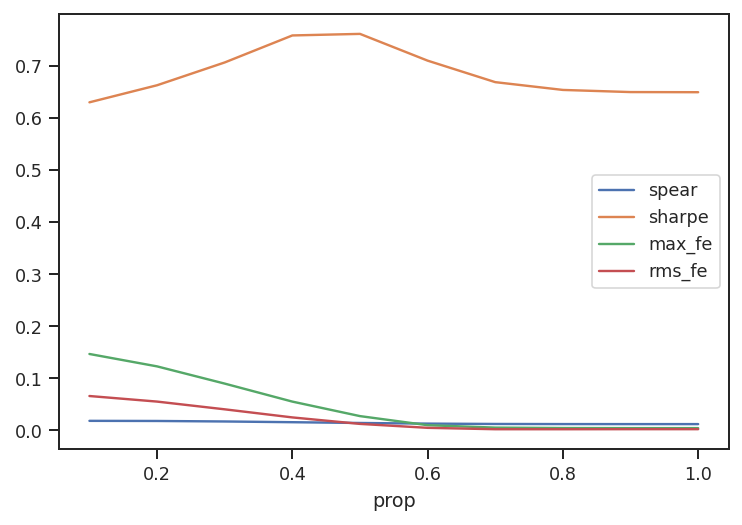

time: 284 ms (started: 2021-04-02 17:32:27 +00:00)


In [ ]:
df_res.plot(x='prop')

## Making Predictions with the final model

In [ ]:
# PyTorch version
print(df_tourn.shape)
df_predictions = df_tourn.reset_index()[['id']]
print(df_predictions.shape)
testloader = DataLoader(NumeraiDataset(df_tourn), batch_size=2**12, shuffle=False, num_workers=CPUs)
preds = []
with torch.no_grad():
    for data in testloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        predicted = list(net.predict(inputs).cpu().numpy())
        preds.extend(predicted)
df_tourn['prediction'] = preds
print(df_tourn.shape)

print('Scoring predictions on validation data...')
_df = df_tourn[df_tourn.data_type == 'validation']
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)

# Free up memory
# del df_tourn

df_predictions['prediction'] = preds
print(df_predictions.shape)

(1720183, 314)
(1720183, 1)
(1720183, 314)
Scoring predictions on validation data...
Spearman:	0.0215
Sharpe:		0.9875
Max exposure:	0.1931
RMS exposure:	0.0816
(1720183, 2)
time: 2min 35s (started: 2021-05-16 19:38:18 +00:00)


In [ ]:
df_predictions.prediction.describe().round(3)

count    1720183.000
mean           0.500
std            0.029
min            0.211
25%            0.489
50%            0.498
75%            0.509
max            0.792
Name: prediction, dtype: float64

time: 62.8 ms (started: 2021-05-16 19:40:59 +00:00)


# Submission

In [ ]:
PRED_FILENAME = f"{RESULTDIR}/predictions_{MODEL_NAME}_{napi.get_current_round()}.csv"

if SAVE_PREDS:
    df_predictions.to_csv(PRED_FILENAME, index=False)

if PRED_FILENAME is not None and UPLOAD_PREDS:
    napi.upload_predictions(PRED_FILENAME, model_id=MODEL_ID)

2021-05-16 19:35:41,612 INFO numerapi.base_api: uploading predictions...


time: 28.9 s (started: 2021-05-16 19:35:35 +00:00)


# Feature selection

In [ ]:
model = sklearn.linear_model.LassoCV()
model = model.fit(df[df.data_type=='train'][RAW_FEAT_COLS], df[df.data_type=='train']['target'])

# Evaluate the model on validation set
_df = df[df.data_type=='validation'].copy()
_df['prediction'] = model.predict(_df[RAW_FEAT_COLS])
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)
# visualise_feat_exposure(df, model, FEAT_COLS, RAW_FEAT_COLS

# Calculate which features are in 95th percentile of predictiveness (based on beta-coefs)
df_coefs = pd.DataFrame({'feature': RAW_FEAT_COLS, 'coef': model.coef_})
df_coefs['abs'] = np.abs(df_coefs.coef)
df_coefs.sort_values(by='abs', ascending=False, inplace=True)
thresh = df_coefs['abs'].quantile(0.90) # 95th percentile
print(thresh)
TOP_RAW_FEATS = list(df_coefs[df_coefs['abs'] >= thresh].feature.values)
print(TOP_RAW_FEATS)

In [ ]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

corr = df[FEAT_COLS].corr()
print(corr.shape)

(1553, 1553)
time: 54min 38s (started: 2021-04-21 22:05:36 +00:00)


(1553, 1553)
(1205128,)
(1552, 4)


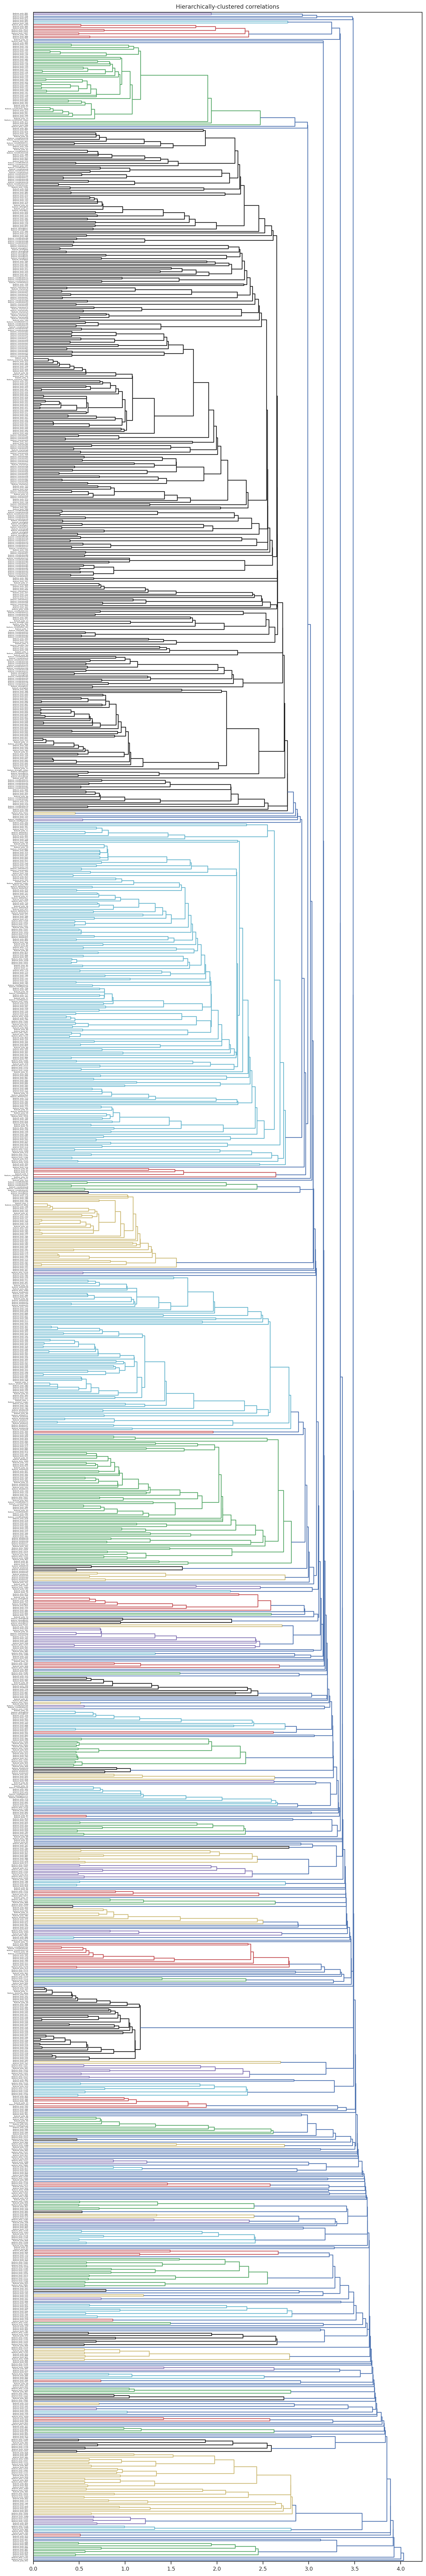

time: 21.6 s (started: 2021-04-21 23:03:37 +00:00)


In [ ]:
# https://stackoverflow.com/questions/38070478/how-to-do-clustering-using-the-matrix-of-correlation-coefficients
_corr = 1 - np.abs(corr)
print(_corr.shape)
dists = pdist(_corr, 'euclidean')
print(dists.shape)
Z = hierarchy.linkage(dists, 'single')
print(Z.shape)
fig, ax = plt.subplots(1, 1, figsize=(10, 60))
dg = hierarchy.dendrogram(Z, ax=ax, orientation='right', labels=FEAT_COLS, leaf_font_size=3)
plt.title('Hierarchically-clustered correlations')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import AffinityPropagation

clustering = AffinityPropagation().fit(_corr)
clustering.cluster_centers_.shape
corr_clust = pd.DataFrame({'feature': _corr.index, 'cluster': clustering.labels_})
# Grab first feature from each cluster
_feats = [corr_clust[corr_clust.cluster == c].head(1)['feature'].values[0] for c in corr_clust.cluster.unique()]
print(_feats)

for f in NB_FEATS:
    print(f, corr_clust[corr_clust.feature == f].cluster.head(1).values[0])

model = sklearn.linear_model.LinearRegression()
model = model.fit(df[df.data_type=='train'][_feats], df[df.data_type=='train']['target'])

# Evaluate the model on validation set
_df = df[df.data_type=='validation'].copy()
_df['prediction'] = model.predict(_df[_feats])
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)
# visualise_feat_exposure(df, model, FEAT_COLS, RAW_FEAT_COLS

['feature_intelligence1', 'feature_intelligence2', 'feature_intelligence5', 'feature_intelligence6', 'feature_intelligence9', 'feature_charisma1', 'feature_charisma2', 'feature_charisma6', 'feature_charisma8', 'feature_charisma10', 'feature_charisma11', 'feature_charisma16', 'feature_charisma31', 'feature_charisma43', 'feature_strength1', 'feature_strength2', 'feature_strength3', 'feature_strength10', 'feature_strength11', 'feature_strength13', 'feature_strength14', 'feature_strength15', 'feature_dexterity2', 'feature_dexterity4', 'feature_dexterity6', 'feature_dexterity12', 'feature_constitution1', 'feature_constitution2', 'feature_constitution5', 'feature_constitution12', 'feature_constitution14', 'feature_constitution22', 'feature_constitution38', 'feature_constitution56', 'feature_wisdom1', 'feature_wisdom2', 'feature_wisdom3', 'feature_wisdom6', 'feature_wisdom10', 'feature_wisdom23', 'feature_wisdom28', 'feature_wisdom31', 'feature_intelligence_mean', 'feature_intelligence_std', 

In [ ]:
from sklearn.feature_selection import RFE
estimator = sklearn.linear_model.Lasso()
selector = RFE(estimator, n_features_to_select=400, step=10, verbose=1)
selector = selector.fit(df[df.data_type=='train'][FEAT_COLS], df[df.data_type=='train']['target'])

In [ ]:
df_feats = pd.DataFrame({'feature': FEAT_COLS, 'rank': selector.ranking_})
df_feats.sort_values(by='rank', ascending=True).head()

,feature,rank
1552,feature_poly_1224,1
320,feature_dexterity_std,1
319,feature_dexterity_mean,1
318,feature_charisma_skew,1
317,feature_charisma_std,1


time: 15.2 ms (started: 2021-04-21 23:42:06 +00:00)


In [ ]:
STRONG_FEATS = list(df_feats[df_feats['rank'] == 1].feature.values)
STRONG_FEATS

['feature_strength19',
 'feature_strength20',
 'feature_strength21',
 'feature_strength22',
 'feature_strength23',
 'feature_strength24',
 'feature_strength25',
 'feature_strength26',
 'feature_strength27',
 'feature_strength28',
 'feature_strength29',
 'feature_strength30',
 'feature_strength31',
 'feature_strength32',
 'feature_strength33',
 'feature_strength34',
 'feature_strength35',
 'feature_strength36',
 'feature_strength37',
 'feature_strength38',
 'feature_dexterity1',
 'feature_dexterity2',
 'feature_dexterity3',
 'feature_dexterity4',
 'feature_dexterity5',
 'feature_dexterity6',
 'feature_dexterity7',
 'feature_dexterity8',
 'feature_dexterity9',
 'feature_dexterity10',
 'feature_dexterity11',
 'feature_dexterity12',
 'feature_dexterity13',
 'feature_dexterity14',
 'feature_constitution1',
 'feature_constitution2',
 'feature_constitution3',
 'feature_constitution4',
 'feature_constitution5',
 'feature_constitution6',
 'feature_constitution7',
 'feature_constitution8',
 'fea

time: 9.87 ms (started: 2021-04-21 23:42:06 +00:00)


In [ ]:
model = sklearn.linear_model.LinearRegression()
model = model.fit(df[df.data_type=='train'][STRONG_FEATS], df[df.data_type=='train']['target'])

# Evaluate the model on validation set
_df = df[df.data_type=='validation'].copy()
_df['prediction'] = model.predict(_df[STRONG_FEATS])
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)
# visualise_feat_exposure(df, model, FEAT_COLS, RAW_FEAT_COLS

Spearman:	0.0162
Sharpe:		0.5148
Max exposure:	0.2110
RMS exposure:	0.0882
time: 44.2 s (started: 2021-04-21 23:42:06 +00:00)


In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
from xgboost import XGBRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, make_scorer

_df = df[df.data_type=='train'].copy().sample(frac=1.0)
X, y = _df[FEAT_COLS], _df['target']

# Fit a decent model
clf = XGBRegressor(max_depth=4, learning_rate=0.02, n_estimators=50, n_jobs=1, colsample_bytree=0.1)
clf = clf.fit(X, y)

# Evaluate the model on validation set
_df = df[df.data_type=='validation'].copy()
_df['prediction'] = clf.predict(_df[FEAT_COLS])
val_corr, val_sharpe, max_fe, rms_fe = scores(_df, verbose=True)

# Estimate feature importance with permuation method
result = permutation_importance(
    clf, X, y, n_repeats=3, random_state=42,
    scoring=make_scorer(score_spear, greater_is_better=True),
    )

[12:43:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Spearman:	0.0188
Sharpe:		0.6090
Max exposure:	0.2893
RMS exposure:	0.1218
time: 59min 56s (started: 2021-05-09 12:43:14 +00:00)


In [ ]:
df_imps = pd.DataFrame({'feature': FEAT_COLS, 'imp_mean': result.importances_mean, 'imp_std': result.importances_std})
print(list(df_imps.sort_values('imp_mean', ascending=False).feature))

['feature_dexterity6', 'feature_charisma63', 'feature_dexterity4', 'feature_dexterity12', 'feature_wisdom23', 'feature_wisdom42', 'feature_dexterity7', 'feature_charisma58', 'feature_dexterity3', 'feature_strength34', 'feature_strength14', 'feature_charisma69', 'feature_intelligence4', 'feature_wisdom32', 'feature_charisma85', 'feature_dexterity5', 'feature_charisma57', 'feature_constitution12', 'feature_wisdom4', 'feature_constitution30', 'feature_charisma9', 'feature_strength1', 'feature_strength22', 'feature_dexterity8', 'feature_strength4', 'feature_strength3', 'feature_charisma19', 'feature_constitution2', 'feature_intelligence3', 'feature_charisma54', 'feature_dexterity11', 'feature_strength19', 'feature_constitution36', 'feature_constitution67', 'feature_charisma11', 'feature_constitution26', 'feature_constitution45', 'feature_constitution102', 'feature_wisdom25', 'feature_charisma78', 'feature_wisdom34', 'feature_charisma21', 'feature_constitution50', 'feature_constitution114',

In [ ]:
PERM_FEATS = ['feature_dexterity6', 'feature_charisma63', 'feature_dexterity4', 'feature_dexterity12', 'feature_wisdom23', 'feature_wisdom42', 'feature_dexterity7', 'feature_charisma58', 'feature_dexterity3', 'feature_strength34', 'feature_strength14', 'feature_charisma69', 'feature_intelligence4', 'feature_wisdom32', 'feature_charisma85', 'feature_dexterity5', 'feature_charisma57', 'feature_constitution12', 'feature_wisdom4', 'feature_constitution30', 'feature_charisma9', 'feature_strength1', 'feature_strength22', 'feature_dexterity8', 'feature_strength4', 'feature_strength3', 'feature_charisma19', 'feature_constitution2', 'feature_intelligence3', 'feature_charisma54', 'feature_dexterity11', 'feature_strength19', 'feature_constitution36', 'feature_constitution67', 'feature_charisma11', 'feature_constitution26', 'feature_constitution45', 'feature_constitution102', 'feature_wisdom25', 'feature_charisma78', 'feature_wisdom34', 'feature_charisma21', 'feature_constitution50', 'feature_constitution114', 'feature_wisdom20', 'feature_constitution34', 'feature_wisdom1', 'feature_intelligence6', 'feature_intelligence8', 'feature_wisdom22', 'feature_constitution110', 'feature_charisma66', 'feature_constitution47', 'feature_wisdom16', 'feature_constitution38', 'feature_charisma42', 'feature_charisma10', 'feature_constitution59', 'feature_wisdom36', 'feature_wisdom14', 'feature_charisma76', 'feature_constitution8', 'feature_wisdom8', 'feature_constitution16', 'feature_charisma18', 'feature_constitution85', 'feature_constitution41', 'feature_charisma53', 'feature_wisdom44', 'feature_strength13', 'feature_charisma55', 'feature_strength7', 'feature_strength23', 'feature_wisdom37', 'feature_charisma40', 'feature_dexterity14', 'feature_charisma61', 'feature_strength9', 'feature_wisdom12', 'feature_charisma1', 'feature_wisdom5', 'feature_constitution62', 'feature_charisma7', 'feature_wisdom10', 'feature_constitution104', 'feature_constitution10', 'feature_constitution112', 'feature_charisma52', 'feature_constitution100', 'feature_wisdom31', 'feature_charisma68', 'feature_constitution15', 'feature_intelligence9', 'feature_wisdom18', 'feature_constitution73', 'feature_charisma46', 'feature_constitution31', 'feature_wisdom13', 'feature_strength5', 'feature_constitution6', 'feature_charisma26', 'feature_constitution69', 'feature_constitution72', 'feature_charisma36', 'feature_charisma33', 'feature_constitution20', 'feature_wisdom43', 'feature_charisma79', 'feature_wisdom28', 'feature_wisdom26', 'feature_constitution33', 'feature_strength32', 'feature_charisma72', 'feature_constitution19', 'feature_wisdom15', 'feature_charisma50', 'feature_charisma29', 'feature_constitution7', 'feature_charisma71', 'feature_intelligence12', 'feature_intelligence11', 'feature_constitution81', 'feature_wisdom45', 'feature_charisma15', 'feature_wisdom41', 'feature_constitution91', 'feature_constitution25', 'feature_charisma74', 'feature_charisma83', 'feature_strength35', 'feature_constitution75', 'feature_constitution53', 'feature_constitution9', 'feature_constitution57', 'feature_wisdom30', 'feature_wisdom11', 'feature_dexterity10', 'feature_charisma67', 'feature_charisma37', 'feature_strength15', 'feature_wisdom24', 'feature_strength25', 'feature_strength16', 'feature_constitution98', 'feature_strength12', 'feature_charisma47', 'feature_wisdom21', 'feature_charisma81', 'feature_constitution87', 'feature_constitution88', 'feature_charisma12', 'feature_constitution106', 'feature_wisdom40', 'feature_strength11', 'feature_dexterity1', 'feature_strength29', 'feature_constitution80', 'feature_charisma75', 'feature_charisma32', 'feature_strength36', 'feature_charisma43', 'feature_strength28', 'feature_charisma14', 'feature_constitution14', 'feature_constitution27', 'feature_wisdom35', 'feature_constitution48', 'feature_constitution52', 'feature_constitution82', 'feature_constitution68', 'feature_charisma62', 'feature_charisma73', 'feature_charisma80', 'feature_constitution95', 'feature_constitution43', 'feature_charisma5', 'feature_wisdom7', 'feature_charisma48', 'feature_constitution107', 'feature_charisma35', 'feature_strength38', 'feature_constitution89', 'feature_wisdom29', 'feature_constitution77', 'feature_constitution84', 'feature_constitution111', 'feature_charisma23', 'feature_constitution65', 'feature_wisdom3', 'feature_constitution108', 'feature_constitution78', 'feature_constitution44', 'feature_charisma6', 'feature_constitution3', 'feature_strength26', 'feature_constitution61', 'feature_dexterity9', 'feature_constitution103', 'feature_constitution18', 'feature_constitution63', 'feature_strength33', 'feature_strength6', 'feature_charisma44', 'feature_charisma82', 'feature_constitution70', 'feature_charisma59', 'feature_constitution13', 'feature_intelligence10', 'feature_constitution83', 'feature_charisma70', 'feature_dexterity13', 'feature_strength18', 'feature_constitution11', 'feature_intelligence2', 'feature_wisdom33', 'feature_charisma17', 'feature_strength21', 'feature_strength30', 'feature_constitution105', 'feature_constitution76', 'feature_constitution101', 'feature_strength20', 'feature_intelligence5', 'feature_constitution56', 'feature_constitution29', 'feature_constitution42', 'feature_charisma49', 'feature_dexterity2', 'feature_strength27', 'feature_charisma13', 'feature_constitution54', 'feature_constitution97', 'feature_constitution99', 'feature_wisdom17', 'feature_constitution109', 'feature_constitution113', 'feature_wisdom39', 'feature_wisdom38', 'feature_wisdom2', 'feature_wisdom19', 'feature_wisdom6', 'feature_wisdom9', 'feature_constitution96', 'feature_intelligence1', 'feature_constitution94', 'feature_charisma39', 'feature_constitution93', 'feature_strength10', 'feature_strength8', 'feature_strength2', 'feature_charisma84', 'feature_charisma77', 'feature_charisma65', 'feature_charisma64', 'feature_charisma60', 'feature_charisma56', 'feature_charisma51', 'feature_charisma45', 'feature_charisma41', 'feature_charisma38', 'feature_strength31', 'feature_charisma31', 'feature_charisma30', 'feature_charisma28', 'feature_charisma27', 'feature_charisma25', 'feature_charisma24', 'feature_charisma22', 'feature_charisma20', 'feature_charisma8', 'feature_charisma4', 'feature_charisma3', 'feature_charisma2', 'feature_intelligence7', 'feature_strength24', 'feature_strength17', 'feature_constitution46', 'feature_constitution40', 'feature_constitution92', 'feature_constitution90', 'feature_constitution86', 'feature_constitution79', 'feature_constitution74', 'feature_constitution71', 'feature_constitution66', 'feature_constitution64', 'feature_constitution60', 'feature_constitution58', 'feature_constitution55', 'feature_constitution51', 'feature_constitution49', 'feature_wisdom46', 'feature_constitution39', 'feature_constitution24', 'feature_constitution4', 'feature_constitution5', 'feature_constitution17', 'feature_constitution21', 'feature_constitution22', 'feature_constitution23', 'feature_constitution28', 'feature_constitution32', 'feature_constitution35', 'feature_constitution37', 'feature_constitution1', 'feature_strength37', 'feature_wisdom27', 'feature_charisma34', 'feature_charisma86', 'feature_charisma16']
print(len(PERM_FEATS))

310
time: 14.9 ms (started: 2021-05-09 14:42:29 +00:00)


# Grid search

In [ ]:
# Take a stratified sample of the training data
train_sample = df[df.data_type == 'train'].groupby('era', group_keys=False).apply(lambda x: x.sample(frac=0.25))

# Grid search
gs = GridSearchCV(
    estimator=ChunkEnsemble(),
    # scoring=make_scorer(mean_squared_error, greater_is_better=False),
    scoring=make_scorer(score_spear, greater_is_better=True),
    param_grid={
        'n_subs': [3, 5, 10, 15],
        'subalg': [XGBRegressor],
        'mainalg': [RidgeCV, LassoCV],
        'feat_cols': [RAW_FEAT_COLS, FEAT_COLS],
    },
    cv=3,
    n_jobs=1,
    verbose=3,
)
gs.fit(train_sample, train_sample['target'])

df_cv = pd.DataFrame(gs.cv_results_)
df_cv.to_csv(f"{RESULTDIR}/grid_search.csv")
print(gs.best_score_)
print(gs.best_params_)
df_cv.sort_values('rank_test_score', ascending=True)

In [ ]:
# Important raw features (from a LassoCV on whole train set)
NB_FEATS = ['feature_dexterity6', 'feature_charisma63', 'feature_strength34', 'feature_dexterity7', 'feature_strength19', 'feature_strength1', 'feature_wisdom23', 'feature_wisdom35', 'feature_constitution38', 'feature_charisma58', 'feature_dexterity12', 'feature_intelligence2', 'feature_constitution63', 'feature_wisdom36', 'feature_wisdom20', 'feature_dexterity14', 'feature_wisdom1', 'feature_charisma10', 'feature_dexterity9', 'feature_intelligence3', 'feature_constitution56', 'feature_wisdom22', 'feature_wisdom38', 'feature_charisma85', 'feature_constitution75', 'feature_charisma18', 'feature_intelligence4', 'feature_strength4', 'feature_constitution96', 'feature_dexterity1', 'feature_intelligence7']

# Feature engineering

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, MinMaxScaler

summary_feats = []

for g, cols in FEAT_GROUPS.items():
    print(g, len(cols))
    # Train/val data
    df[f"feature_{g}_mean"] = df[cols].mean(axis=1).astype(np.float16)
    df[f"feature_{g}_std"] = df[cols].std(axis=1).astype(np.float16)
    df[f"feature_{g}_skew"] = df[cols].skew(axis=1).astype(np.float16)
    # Tournament data
    # df_tourn[f"feature_{g}_mean"] = df_tourn[cols].mean(axis=1).astype(np.float16)
    # df_tourn[f"feature_{g}_std"] = df_tourn[cols].std(axis=1).astype(np.float16)
    # df_tourn[f"feature_{g}_skew"] = df_tourn[cols].skew(axis=1).astype(np.float16)

    meta_feats = [f"feature_{g}_mean", f"feature_{g}_std", f"feature_{g}_skew"]
    summary_feats.extend(meta_feats)

    # df[meta_feats].hist()
    # plt.tight_layout()
    # plt.show()

# Polynomial interaction
interaction_feats = summary_feats
interaction_feats.extend(NB_FEATS)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
_sample = df[df.data_type == 'train']
poly.fit(_sample[interaction_feats], _sample['target'])
_new = poly.transform(df[interaction_feats]).astype('float16')
_df = pd.DataFrame(data=_new, index=df.index, columns=[f"feature_poly_{i}" for i in range(_new.shape[1])], dtype=np.float16)
df = pd.concat([df, _df], axis=1)

# Garbage collection
del _sample
del poly
del _new
del _df

# Re-scale all trainable features
print('Rescaling...')
FEAT_COLS = [f for f in df.columns if "feature" in f]
ENG_FEATS = [f for f in FEAT_COLS if f not in RAW_FEAT_COLS]
print(len(FEAT_COLS), len(ENG_FEATS))
for c in tqdm(ENG_FEATS):
    df[c] = MinMaxScaler().fit_transform(df[c].values.reshape(-1, 1))

print(f"Engineered {len(ENG_FEATS)} features. New total: {len(FEAT_COLS)}")

In [ ]:
# Find any columns that have nans or infinite values
df.columns[(df.replace([np.inf, -np.inf], np.nan).isna().sum().values > 0)]

In [ ]:
df[ENG_FEATS[-20:]].describe()

In [ ]:
df.info()

In [ ]:
df.sample(5)